# Assoziationsanalyse - Python-Beispiel

Leider bietet `scikit-learn` kein Verfahren für die Assoziationsanalyse direkt an. Allerdings gibt es das Paket [Mlxtend](https://github.com/rasbt/mlxtend) von [Sebastian Raschka](https://sebastianraschka.com/), mit dem sich Assoziationsregeln finden lassen. Ein Tutorial dazu findet sich auf der Website [Practical Business Python](http://pbpython.com/market-basket-analysis.html). Zunächst imprtieren wir wieder die benötigten Bibliotheken.

In [1]:
import csv
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.preprocessing import OnehotTransactions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Nun lesen wir den zuvor aus R exportierten Datensatz hier wieder ein und zwar in Form einer Liste, die wir dann mit den `Mlxtend`-Methoden weiter verarbeiten werden.

In [2]:
with open('data/groceries_r_quoted.csv', 'r') as f:
    reader = csv.reader(f)
    transactions = list(reader)
transactions

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product'],
 ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'],
 ['rolls/buns'],
 ['other vegetables',
  'UHT-milk',
  'rolls/buns',
  'bottled beer',
  'liquor (appetizer)'],
 ['pot plants'],
 ['whole milk', 'cereals'],
 ['tropical fruit',
  'other vegetables',
  'white bread',
  'bottled water',
  'chocolate'],
 ['citrus fruit',
  'tropical fruit',
  'whole milk',
  'butter',
  'curd',
  'yogurt',
  'flour',
  'bottled water',
  'dishes'],
 ['beef'],
 ['frankfurter', 'rolls/buns', 'soda'],
 ['chicken', 'tropical fruit'],
 ['butter', 'sugar', 'fruit/vegetable juice', 'newspapers'],
 ['fruit/vegetable juice'],
 ['packaged fruit/vegetables'],
 ['chocolate'],
 ['specialty bar'],
 ['other vegetables'],
 ['butter milk

Wir benötigen zunächst ein [One Hot Encoding](http://rasbt.github.io/mlxtend/user_guide/preprocessing/OnehotTransactions/) der eingelesenen Daten, aber diesmal explizit. Dies tun wir wiederum mit dem aus `scikit-learn` bekannten *fit-transform* Vorgehen und das Ergebnis speichern wir in ein Data Frame.

In [3]:
oht = OnehotTransactions()
oht_ary = oht.fit(transactions).transform(transactions)
transactdf = pd.DataFrame(oht_ary, columns=oht.columns_)
transactdf.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Vorbetrachtungen
Leider können wir die Matrix in Python nicht so schön visualisieren wie in R. Stattdessen berechnen wir wieder das Maß für die Dünnbesetztheit auf die Weise, wie wir es bereits von den Matrizen bei der Textklassifikation kennen.

In [4]:
ntransact = transactdf.shape[0]
ntransact

9835

In [5]:
nitems = transactdf.shape[1]
nitems

169

In [6]:
nnz = np.count_nonzero(transactdf)
nnz

43367

In [7]:
sparsity = 100 * nnz / (ntransact*nitems)
print("Die Merkmalsmatrix hat ~{0:.2f}% von Null verschiedene Einträge.".format(sparsity))

Die Merkmalsmatrix hat ~2.61% von Null verschiedene Einträge.


Um auch hier die Häufigkeiten plotten zu können, generieren wir zunächst eine Liste der Supportwerte, die wir anschließend wieder geeignet filtern und visualisieren können. 

In [8]:
supplist = transactdf.sum().sort_values(ascending=False)/ntransact
supplist.head()

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
dtype: float64

In [9]:
supplist[supplist>=0.1]

whole milk          0.255516
other vegetables    0.193493
rolls/buns          0.183935
soda                0.174377
yogurt              0.139502
bottled water       0.110524
root vegetables     0.108998
tropical fruit      0.104931
dtype: float64

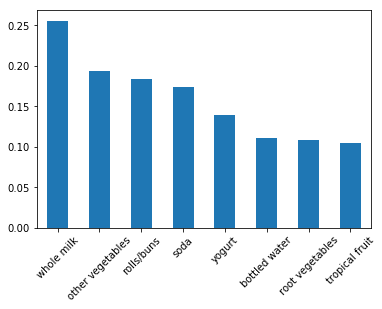

In [10]:
supplist[supplist>=0.1].plot(kind='bar', rot=45)

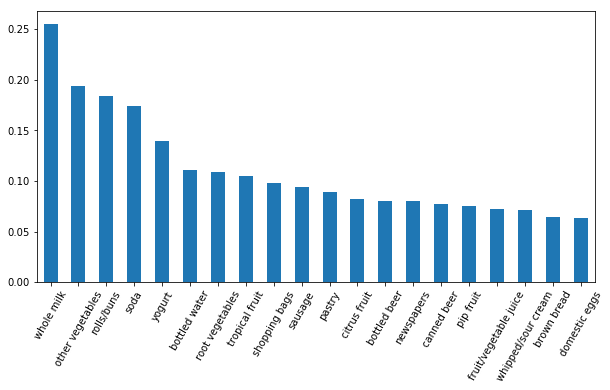

In [11]:
supplist.head(20).plot(kind='bar', rot=60, figsize=(10,5))

## Ermittlung der Regeln

Für die Bestimmung der *large itemsets* verwenden wir auch hier wieder den [a-priori Algorithmus von `Mlxtend`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) und verlangen dabei wieder einen Mindestsupport von 6 Promille.

In [12]:
frequent_itemsets = apriori(transactdf, min_support=0.006, use_colnames=True)

In [13]:
type(frequent_itemsets)

pandas.core.frame.DataFrame

Hier erhalten wir also explizit die large itemsets in einem Pandas Data Frame, aus dem wir uns einen Ausschnitt ansehen.

In [14]:
frequent_itemsets[400:410]

,support,itemsets
400,0.007016,"[hygiene articles, soda]"
401,0.006711,"[hygiene articles, tropical fruit]"
402,0.012811,"[hygiene articles, whole milk]"
403,0.007321,"[hygiene articles, yogurt]"
404,0.006101,"[ice cream, soda]"
405,0.010676,"[long life bakery product, other vegetables]"
406,0.007931,"[long life bakery product, rolls/buns]"
407,0.007626,"[long life bakery product, soda]"
408,0.006304,"[long life bakery product, tropical fruit]"
409,0.013523,"[long life bakery product, whole milk]"


Die *Regeln* werden nun in einem zweiten Schritt generiert, wobei hier flexibel andere Metriken als die Konfidenz eingesetzt werden können. Wir werden aber die gleichen Anforderungen stellen, wie in R auch.

In [16]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
rules.head()

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(baking powder),(other vegetables),0.017692,0.193493,0.007321,0.413793,2.138547,0.003898,1.375807
1,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725
2,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416
3,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,1.411858,0.003975,1.102329
4,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628


In [17]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 9 columns):
antecedants           467 non-null object
consequents           467 non-null object
antecedent support    467 non-null float64
consequent support    467 non-null float64
support               467 non-null float64
confidence            467 non-null float64
lift                  467 non-null float64
leverage              467 non-null float64
conviction            467 non-null float64
dtypes: float64(7), object(2)
memory usage: 32.9+ KB


Es fällt auf, dass die Darstellung eine etwas andere ist als in R und dass zwei neune Metriken, nämlich *leverage* und *conviction* mit angegeben werden (mehr dazu in den Übungen). Hier wird auch eine andere gebräuchliche Begrifflichkeit für die Regeln verwendet, indem die Voraussetzung als *antededent* (das ist die richtige Schreibweise ...) und der Schluss als *consequent* bezeichnet wird.

Was allerdings fehlt, ist die *absolute Häufigkeit*, also der *count*. Da wir es nun aber mit einem Data Frame zu tun haben, können wir diesem einfach eine neue Spalte hinzufügen, die diesen enthält. Dabei berechnen wir ihn aus dem *support* (also der *relativen Häufigkeit*) durch Multiplikation mit der Anzahl aller Transaktionen, wobei wir zur Vermeidung von Rundungsfehlern noch 0.2 dazu addieren, bevor wir das Ergebnis in eine ganze Zahl umwandeln.

In [18]:
rules["count"] = rules.support.apply(lambda x: int(x*ntransact+0.2))
rules.head()

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
0,(baking powder),(other vegetables),0.017692,0.193493,0.007321,0.413793,2.138547,0.003898,1.375807,72
1,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2.046793,0.004732,1.560725,91
2,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,1.943066,0.009574,1.292416,194
3,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,1.411858,0.003975,1.102329,134
4,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628,171


Wie zuvor schauen wir zunächst auf die Regeln mit dem höchten Lift.

In [24]:
rules.sort_values("lift", ascending=False)[1:7]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
461,"(yogurt, root vegetables)","(whole milk, other vegetables)",0.025826,0.074835,0.007829,0.303150,4.050919,0.005896,1.327638,77
81,(herbs),(root vegetables),0.016268,0.108998,0.007016,0.431250,3.956477,0.005243,1.566596,69
7,(berries),(whipped/sour cream),0.033249,0.071683,0.009049,0.272171,3.796886,0.006666,1.275461,89
454,"(tropical fruit, other vegetables, whole milk)",(root vegetables),0.017082,0.108998,0.007016,0.410714,3.768074,0.005154,1.512003,69
151,"(other vegetables, beef)",(root vegetables),0.019725,0.108998,0.007931,0.402062,3.688692,0.005781,1.490123,78
303,"(tropical fruit, other vegetables)",(pip fruit),0.035892,0.075648,0.009456,0.263456,3.482649,0.006741,1.254985,93


Interessanter Weise taucht hierbei eine Regel auf, die zuvor nicht gefunden wurde. Vermutlich liegt das an bestimmten Defaultparametern, die sich in den beiden Implementierungen unterscheiden, aber die übrigen Regeln sind die, die auch in R gefunden wurden.

Etwas schwieriger ist das Finden der Beerenreglen. Hier muss man zunächst wissen, dass es sich bei den *Antecedents* um sog. [frozensets](https://www.python-course.eu/sets_frozensets.php) handelt, so dass man prüfen muss, ob diese eine Obermenge der Menge `{'berries'}` sind.

In [26]:
type(rules.antecedants.values[0])

frozenset

In [20]:
#rules['berries' in rules.antecedants.values]
rules[rules.antecedants.apply(lambda x: x.issuperset({'berries'}))]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
6,(berries),(other vegetables),0.033249,0.193493,0.010269,0.308869,1.596280,0.003836,1.166938,101
7,(berries),(whipped/sour cream),0.033249,0.071683,0.009049,0.272171,3.796886,0.006666,1.275461,89
8,(berries),(whole milk),0.033249,0.255516,0.011795,0.354740,1.388328,0.003299,1.153774,116
9,(berries),(yogurt),0.033249,0.139502,0.010574,0.318043,2.279848,0.005936,1.261807,104


Regeln mit Substitutionseffekt findet man dann wieder sehr leicht.

In [21]:
rules[rules.lift<1.0]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,count
11,(bottled beer),(whole milk),0.080529,0.255516,0.020437,0.253788,0.993237,-0.000139,0.997684,201


Dies alles sollen Sie nun nochmals [einüben](2017-12-15-RvS_Assoziationsanalysen_Uebung.ipynb)

In [27]:
pd.options.display.max_rows = PREVIOUS_MAX_ROWS